##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Use Nano-banana

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/nano-banana-hackathon-kit/blob/main/guides/02-use-nano-banana.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>
  </td>
  <td></td>
  <td><a href="https://aistudio.google.com/apps/bundled/get_started_image_out">Javascript version on AI Studio</a></td>
</table>

This notebook will show you how to use the nano banana multimodal capabilities to output both images and texts, and iterate on an image through a discussion.

This model is really good at:
* **Maintaining character consistency**: Preserve a subject’s appearance across multiple generated images and scenes
* **Performing intelligent editing**: Enable precise, prompt-based edits like inpainting (adding/changing objects), outpainting, and targeted transformations within an image
* **Compose and merge images**: Intelligently combine elements from multiple images into a single, photorealistic composite
* **Leverage multimodal reasoning**: Build features that understand visual context, such as following complex instructions on a hand-drawn diagram

Following this guide, you'll learn how to do all those things and even more.

**Note**: This guide is a simplified version of the [cookbook guide](https://colab.sandbox.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image_out.ipynb#scrollTo=5a3a7f45ea5e) of the nano banana model. Check-out the original version for more examples

## Setup

### Install SDK

In [ ]:
%pip install -U -q "google-genai>=1.32.0" # minimum version needed for the parts accessor

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, check out the [01-getting-your-api-key.ipynb](./01-getting-your-api-key.ipynb) guide.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY') # Or just paste your API Key from AI Studio

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key (or OAuth if using Vertex AI). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select a model

`gemini-2.5-flash-image-preview` is the latest and the state-of-the-art Gemini model capable of generating images.

In [ ]:
MODEL_ID = "gemini-2.5-flash-image-preview"

### Utils

These two functions will help you manage the outputs of the model.

Compared to when you simply generate text, this time the output will contain multiple parts, some one them being text while others will be images. You'll also have to take into account that there could be multiple images so you cannot stop at the first one.


In [ ]:
from IPython.display import display, Markdown, Image
import pathlib

# Loop over all parts and display them either as text or images
def display_response(response):
  for part in response.parts:
    if part.text:
      display(Markdown(part.text))
    elif image:= part.as_image():
      display(image)
      # image.show() if not in a notebook

# Save the image
# If there are multiple ones, only the last one will be saved
def save_image(response, path):
  for part in response.parts:
    if image:= part.as_image():
      image.save(path)

## Generate images

Using the Gemini Image generation model is the same as using any Gemini model: you simply call `generate_content`.

You can set the `response_modalities` to indicate to the model that you are expecting an image in the output but it's optional as this is expected with this model.

Here is your requested image: 

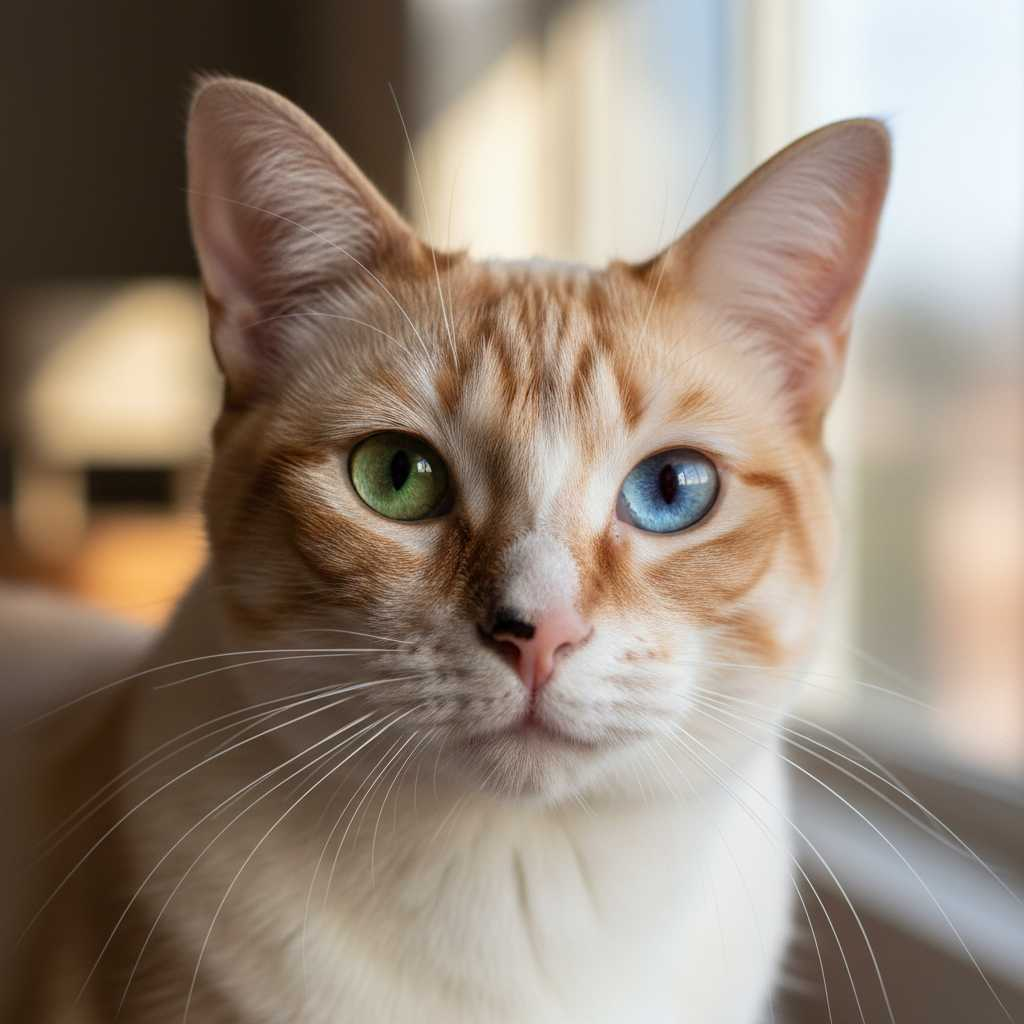

In [ ]:
prompt = 'Create a photorealistic image of a siamese cat with a green left eye and a blue right one and red patches on his face and a black and pink nose' # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

display_response(response)
save_image(response, 'cat.png')

## Edit images

You can also do image editing, simply pass the original image as part of the prompt. Don't limit yourself to simple edit, Gemini is able to keep the character consistency and reprensent you character in different behaviors or places.

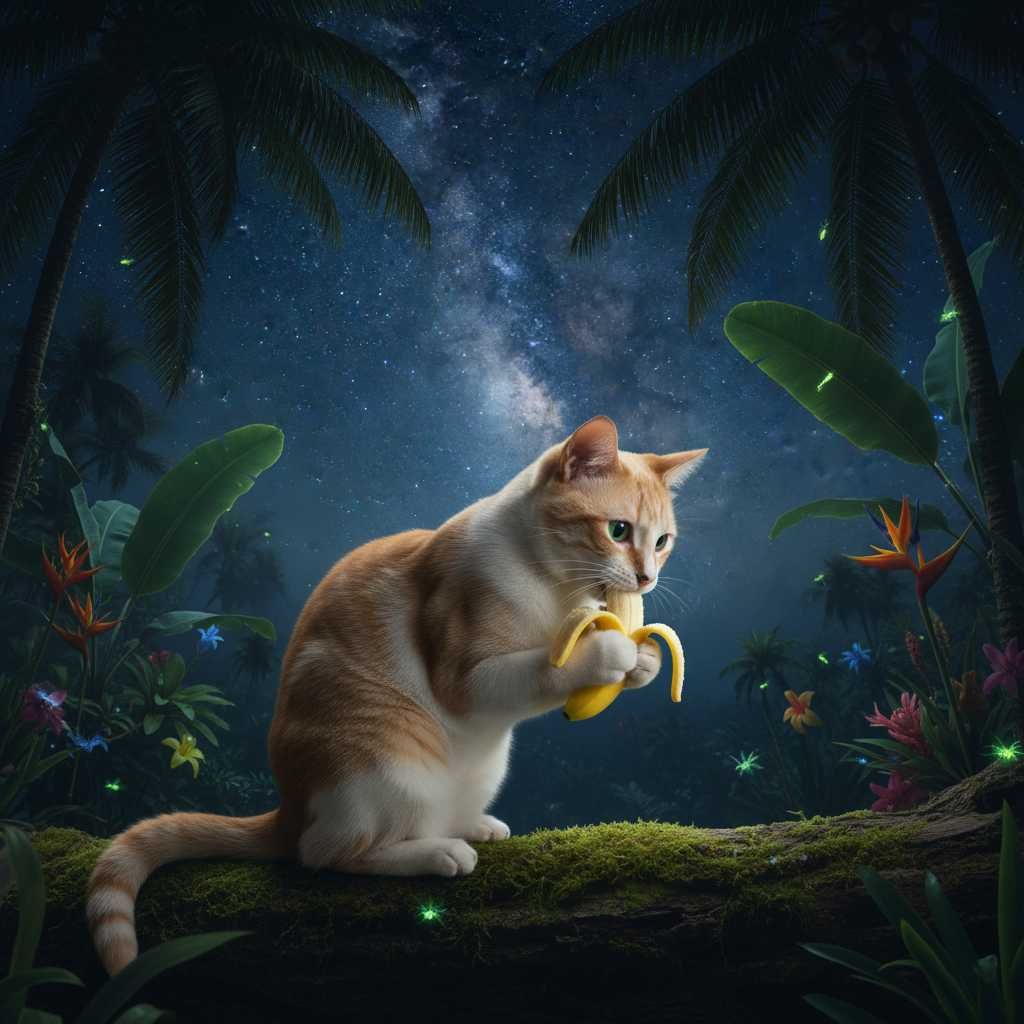

In [ ]:
import PIL

text_prompt = "Create a side view picture of that cat, in a tropical forest, eating a nano-banana, under the stars" # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png')
    ]
)

display_response(response)
save_image(response, 'cat_tropical.png')

## Get multiple images (ex: tell stories)

So far you've only generated one image per call, but you can request way more than that! Let's try a baking receipe or telling a story.

In [ ]:
prompt = "Create a beautifully entertaining 8 part story with 8 images with two blue characters and their adventures in the 1960s music scene. The story is thrilling throughout with emotional highs and lows and ending on a great twist and high note. Do not include any words or text on the images but tell the story purely through the imagery itself. " # @param ["Show me how to bake macarons with images","Create a beautifully entertaining 8 part story with 8 images with two blue characters and their adventures in the 1960s music scene. The story is thrilling throughout with emotional highs and lows and ending on a great twist and high note. Do not include any words or text on the images but tell the story purely through the imagery itself. "] {"allow-input":true}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
)

display_response(response)

# Be careful; long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here are some examples of what it should look like when you run it when asking for a story, or for a baking receipe:

----------
**Prompt**: *Create a beautifully entertaining 8 part story with 8 images with two blue characters and their adventures in the 1960s music scene. The story is thrilling throughout with emotional highs and lows and ending on a great twist and high note. Do not include any words or text on the images but tell the story purely through the imagery itself.*
![Azure tone story](https://storage.googleapis.com/generativeai-downloads/images/azuretones.png)
(Images have been stitched together)


## Chat mode (recommended method)

So far you've used unary calls, but Image-out is actually made to work better with chat mode as it's easier to iterate on an image turn after turn.

In [ ]:
chat = client.chats.create(
    model=MODEL_ID,
)

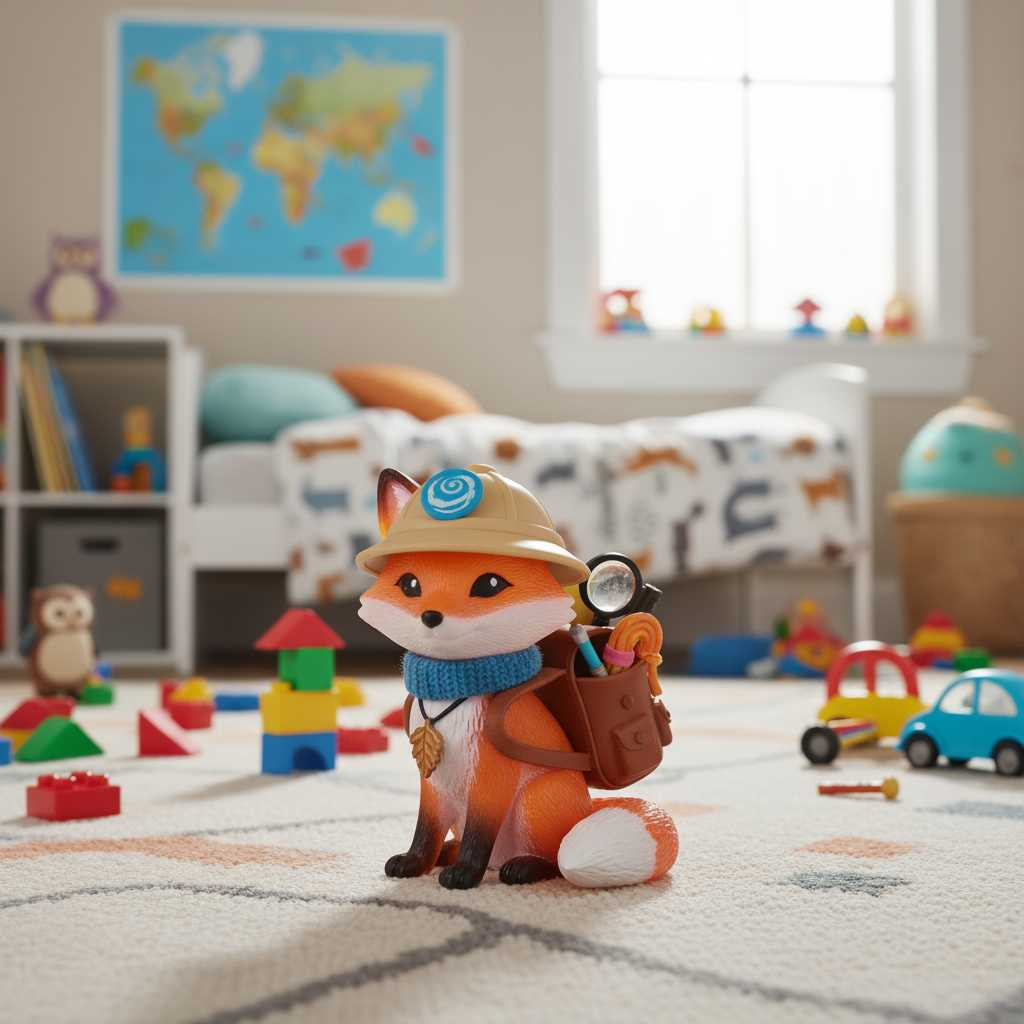

In [ ]:
message = "Create a image of a plastic toy fox figurine with a blue planet on its helmet in a kid's bedroom, it can have accessories but no weapon" # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

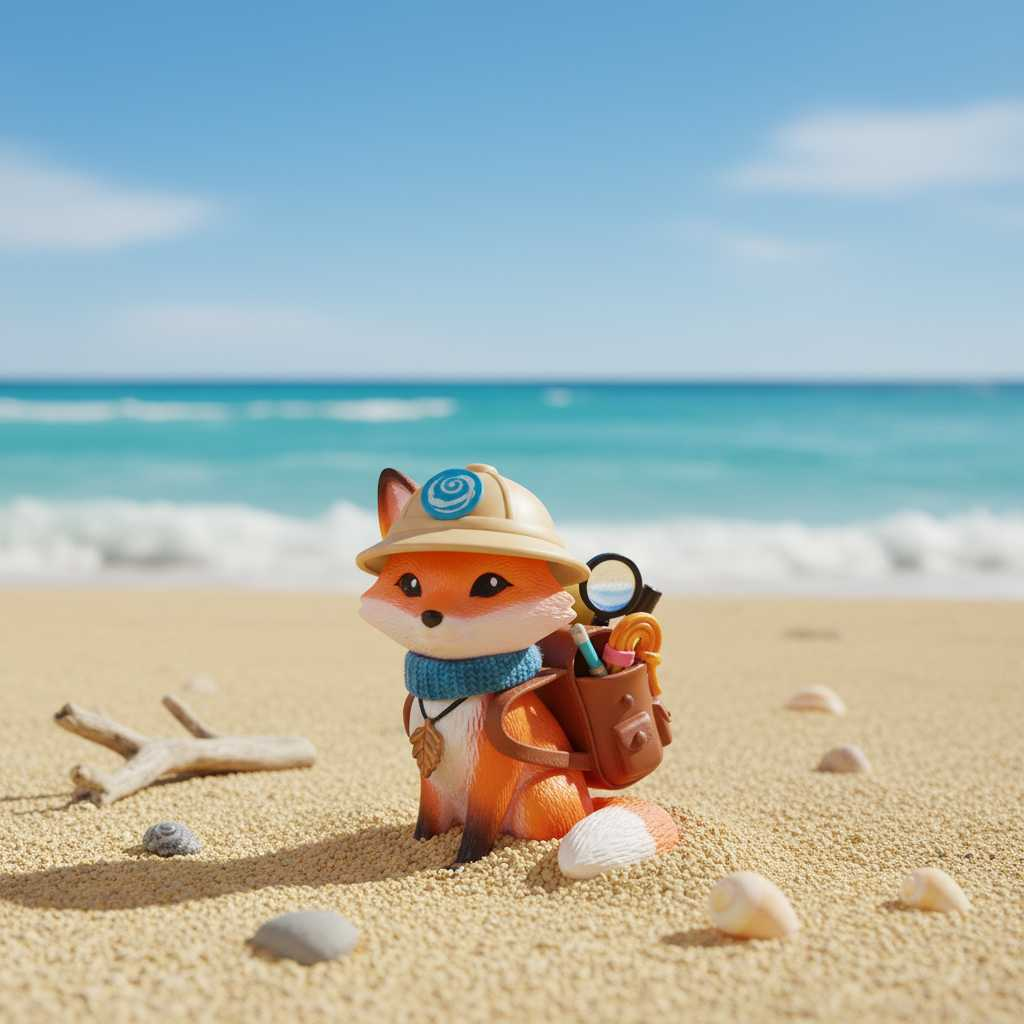

In [ ]:
message = 'Move that figurine on a beach' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

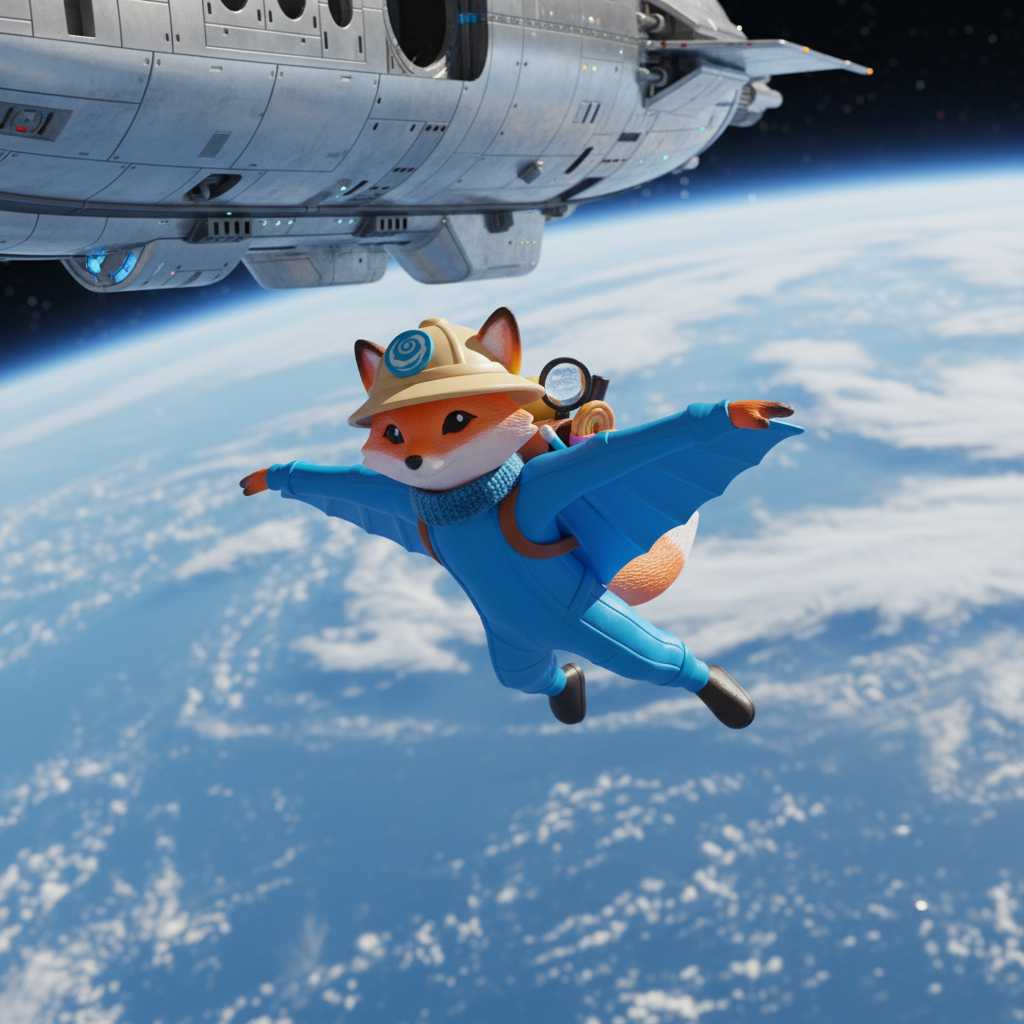

In [ ]:
message = 'Now it should be base-jumping from a spaceship with a wingsuit' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

## Mix multiple pictures

You can also mix multiple images (up to 3), either because there are multiple characters in your image, or because you want to hightlight a certain product, or set the background.

What a fun idea! Here’s that brave figurine riding the cat through a fantastical world. 

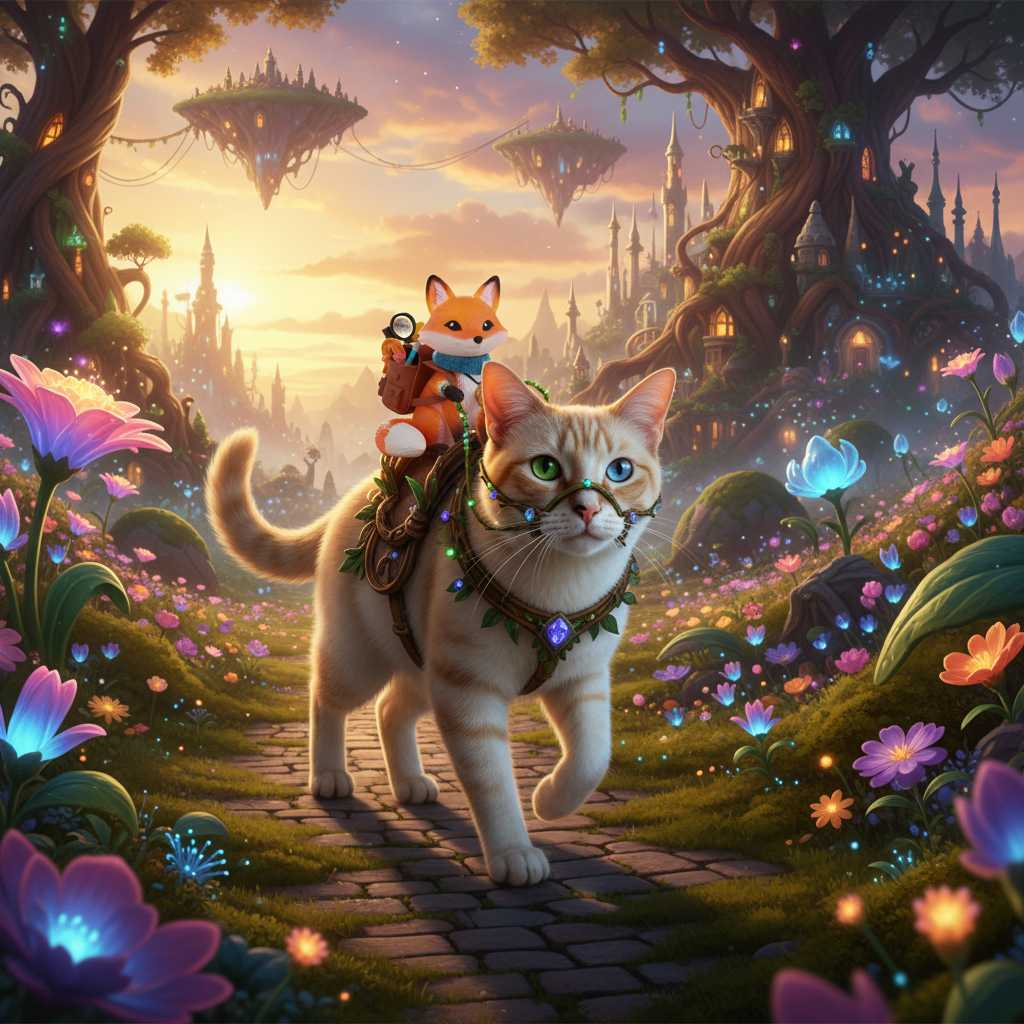

In [ ]:
import PIL

text_prompt = "Create a picture of that figurine riding that cat in a fantasy world." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png'),
        PIL.Image.open('figurine.png')
    ],
)

display_response(response)

## Next Steps
### Useful documentation references:

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#gemini) for more details about the image generation capabilities of the model. To improve your prompting skills, check out the [prompt guide](https://ai.google.dev/gemini-api/docs/image-generation#prompt-guide) for great advices on creating your prompts.

### Play with the AI Studio apps

Theses 5 AI Studio apps are all great showcases of Gemini image generation capabilities:
* [Past Forward](https://aistudio.google.com/apps/bundled/past_forward) lets you travel through time
* [Home Canvas](https://aistudio.google.com/apps/bundled/home_canvas) lets your try out new furniture
* [Gembooth](https://aistudio.google.com/apps/bundled/gembooth) places you into a comic book or a Renaissance painting
* [Gemini Co-drawing](https://aistudio.google.com/apps/bundled/codrawing) lets you draw alongside with Gemini
* [Pixshop](https://aistudio.google.com/apps/bundled/pixshop), an AI-powered image editor